In [2]:
import pandas as pd
import numpy as np
import glob
import os
from pathlib import Path
import requests
import json

crest_df = pd.read_csv(('../data_files/historic_crests_cleaned.csv'))
crest_df


,Unnamed: 0,gaugeId,name,shortName,flood,utc,stage,discharge,rank,yMin,yellowStage,riverMile,adjStage,minStage,maxStage,normStage,stageRangePrecent
0,0,USGS-9,Duvall,Duvall,2022 - March,2022-03-02 10:00:00,41.75,NaN,200.0,15.0,NaN,9,41.75,37.23,41.88,4.52,97.204301
1,1,USGS-9,Duvall,Duvall,2022 - January 7th,2022-01-08 14:30:00,38.81,NaN,200.0,15.0,NaN,9,38.81,37.23,41.88,1.58,33.978495
2,2,USGS-9,Duvall,Duvall,2022 - January 21st,2022-01-21 19:30:00,37.92,NaN,200.0,15.0,NaN,9,37.92,37.23,41.88,0.69,14.838710
3,3,USGS-9,Duvall,Duvall,2022 - January 13th,2022-01-14 01:00:00,40.83,NaN,200.0,15.0,NaN,9,40.83,37.23,41.88,3.60,77.419355
4,4,USGS-9,Duvall,Duvall,2021 - October,2021-10-30 06:00:00,39.56,NaN,200.0,15.0,NaN,9,39.56,37.23,41.88,2.33,50.107527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,117,USGS-38,Below the Falls,Below the Falls,2020 - January,2020-01-07 15:00:00,14.71,24800.0,22.0,0.0,10.52,38,114.71,11.80,17.85,2.91,48.099174
118,118,USGS-38,Below the Falls,Below the Falls,2020 - February 7th,2020-02-07 18:20:00,15.64,29200.0,22.0,0.0,10.52,38,115.64,11.80,17.85,3.84,63.471074
119,119,USGS-38,Below the Falls,Below the Falls,2020 - February 1st,2020-02-01 23:00:00,16.79,37500.0,22.0,0.0,10.52,38,116.79,11.80,17.85,4.99,82.479339
120,120,USGS-38,Below the Falls,Below the Falls,2019 - October,2019-10-22 15:50:00,17.85,46900.0,22.0,0.0,10.52,38,117.85,11.80,17.85,6.05,100.000000


In [3]:
from sklearn import linear_model
SVPA_33 = crest_df[crest_df['gaugeId']=='SVPA-33']
USGS_38 = crest_df[crest_df['gaugeId']=='USGS-38']
floods  = SVPA_33['flood']

X = np.array(USGS_38[USGS_38['flood'].isin(floods)]['stage']).reshape(-1,1)

y = SVPA_33['stage']
regr = linear_model.LinearRegression()
regr.fit(X,y)
regr.score(X,y)

0.900992318409587

In [60]:
from sklearn import linear_model
def build_basic_model(x_gauge_id:str, predict_gauge_id:str):
    x_gauge_df = crest_df[crest_df['gaugeId']==x_gauge_id]
    predict_gauge_df = crest_df[crest_df['gaugeId']==predict_gauge_id]
    x_floods = x_gauge_df['flood']
    y_floods = predict_gauge_df['flood']
    X_matched_df = x_gauge_df[x_gauge_df['flood'].isin(y_floods)]['stage']
    X = np.array(X_matched_df).reshape(-1,1)
    y = predict_gauge_df[predict_gauge_df['flood'].isin(x_floods)]['stage']
    regr = linear_model.LinearRegression()
    regr.fit(X,y)
    score = regr.score(X,y)
    print(regr.coef_, regr.intercept_)
    print(len(y), score)
    return regr, len(y), score, X, y

model,n,score,X,y = build_basic_model('USGS-38', 'SVPA-33')

[0.92843937] 69.77449350905461
11 0.900992318409587


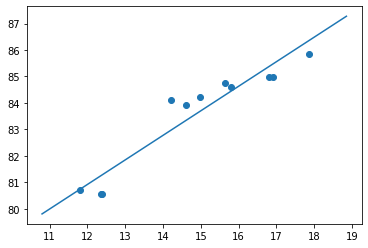

In [61]:
import matplotlib.pyplot as plt

def plot_model(model, X,y):
    xfit = np.linspace(np.min(X)-1, np.max(X)+1, 1000)
    yfit = model.predict(xfit[:, np.newaxis])

    # Plot the estimated linear regression line with matplotlib:
    plt.scatter(X, y)
    plt.plot(xfit, yfit);
    plt.show()

plot_model(model, X,y)

In [84]:
response = requests.get("https://floodzilla.com/api/client/APIGetLocationInfo?regionId=1")
gauges = response.json()
gauges_df = pd.DataFrame(gauges)
gauges_df['riverMile'] = gauges_df['id'].str.extract(r'([0-9]+)', expand=True).astype(int)


USGS-38 => Snoqualmie Falls Golf Course (SVPA-37)
[1.38868716] 70.95623947141281
5 0.9860758801568501


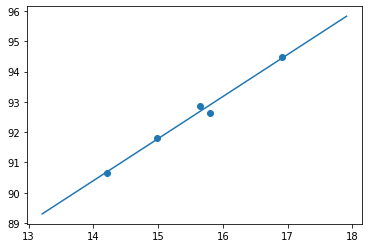

USGS-38 => Fall City- Neal Rd. SE (SVPA-36)
[0.90792192] 65.83715209085227
6 0.9499341697682513


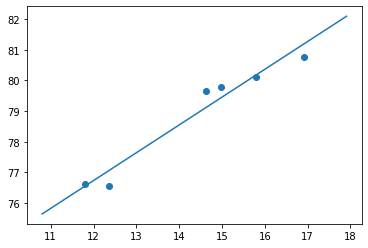

USGS-38 => The "T" at W Snoqualmie River Rd SE (SVPA-34)
[0.82977293] 65.90459966878466
10 0.9703751811601681


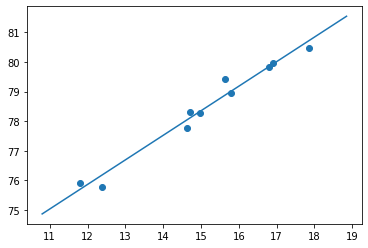

USGS-38 => Snoqualmie River at Keller Dairy (SVPA-33)
[0.92843937] 69.77449350905461
11 0.900992318409587


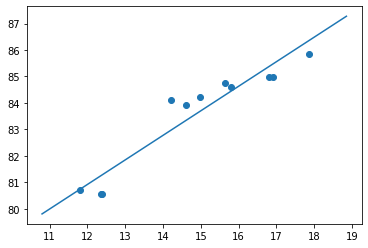

USGS-38 => W Snoqualmie River Rd NE at Blue Heron Golf Course (SVPA-26)
[1.19481756] 54.30180140843191
9 0.9134657960560917


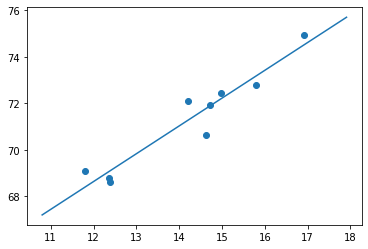

USGS-38 => Snoqualmie River at NE Tolt Hill Rd (SVPA-25)
[1.12152959] 54.18192324333046
8 0.8625520077426572


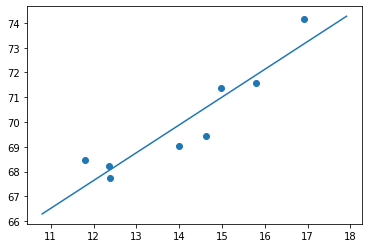

USGS-22 => NE 100th St at Goose & Gander Farm (SVPA-17)
[1.70223562] -43.96246962094723
8 0.9060205304983959


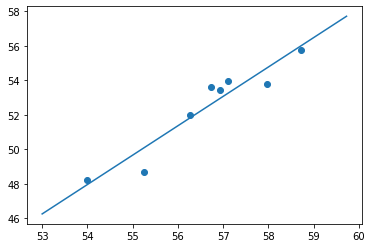

USGS-22 => NE 124th St (East) at Local Roots Farm (SVPA-15)
[1.42490023] -34.191153012056574
13 0.9460139095684447


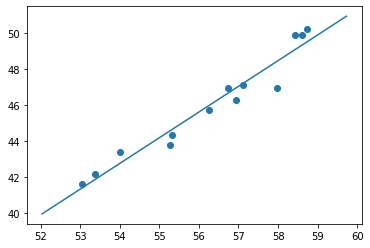

USGS-22 => NE 138th St at Wild Canary Farm (SVPA-12)
[0.93125908] -7.657549780893326
13 0.9467459506996203


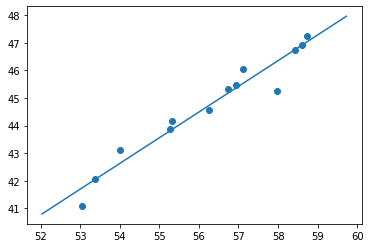

In [85]:

for index, gauge in gauges_df.iterrows():
    x = "foo"
    if gauge['id'] in ["SVPA-23","SVPA-15B"]:
        continue
    if gauge['id'].startswith("USGS"):
        continue
    usgs_gauge = 'USGS-22'
    if gauge['riverMile'] > 22:
        usgs_gauge = 'USGS-38'

    print("{} => {} ({})".format(usgs_gauge, gauge['locationName'], gauge['id']))
    model,n,score,X,y = build_basic_model(usgs_gauge, gauge['id'])
    plot_model(model,X,y)
